In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
PROGRESS_PARAMETERS = "step genpool_size".split()
FIT_PARAMETERS = "min_fit mean_fit max_fit".split()

def get_log_start_index(log_file_text_line_list: str) -> [int]:
    return [i for i, row in enumerate(log_file_text_line_list) if row.startswith("1 ")]

def separate_on_start_index(log_file_name: str) -> [str]:
    with open(log_file_name) as f:
        log_file_text_line_list = f.readlines()

    log_start_index_list = get_log_start_index(log_file_text_line_list)
    assert len(log_start_index_list) == 10

    separated = []
    for i, index in enumerate(log_start_index_list[:-1]):
        next_index = log_start_index_list[i + 1]
        separated.append("".join(log_file_text_line_list[index:next_index]))
    separated.append("".join(log_file_text_line_list[log_start_index_list[-1]:]))
    assert len(separated) == 10
    return separated

def read_df_from_separated_log(separated_log_str):
    log_row_list = separated_log_str.split("\n")[1:] # First is from 1 not 0 - do not consider it for simplicity

    df = pd.DataFrame((row.split(" ") for row in log_row_list), columns=PROGRESS_PARAMETERS + FIT_PARAMETERS)
    data_types = {p: int for p in PROGRESS_PARAMETERS} | {p: float for p in FIT_PARAMETERS}
    df = df.dropna().astype(data_types)

    assert df.shape[0] == 4_000, df.shape[0]

    return df

def read_df_for_each_log(log_file_name: str) -> [pd.DataFrame]:
    return [read_df_from_separated_log(separated_log) for separated_log in separate_on_start_index(log_file_name)]

def get_concat_df(log_file_name_list: str) -> pd.DataFrame:
    df_list = []
    for log_file_name in log_file_name_list:
        for log_index, log_df in enumerate(read_df_for_each_log(log_file_name)):
            log_df["log_index"] = log_index
            log_df["log_index"] = log_df["log_index"].astype(int)

            # Modification 0 = Default
            log_df["file_name"] = log_file_name

            df_list.append(log_df)
    concat_df = pd.concat(df_list)
    df_fit_parameters = concat_df[FIT_PARAMETERS]
    concat_df[FIT_PARAMETERS] = (df_fit_parameters - df_fit_parameters.min()) / (df_fit_parameters.max() - df_fit_parameters.min())
    return concat_df

get_concat_df(["log_default.txt", "log_modified_1.txt"]).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 0 to 3999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   step          80000 non-null  int32  
 1   genpool_size  80000 non-null  int32  
 2   min_fit       80000 non-null  float64
 3   mean_fit      80000 non-null  float64
 4   max_fit       80000 non-null  float64
 5   log_index     80000 non-null  int32  
 6   file_name     80000 non-null  object 
dtypes: float64(3), int32(3), object(1)
memory usage: 4.0+ MB


In [32]:
# seaborn_parameters = {"
#     "style": "darkgrid"
# }
# sns.set(**seaborn_parameters)

def file_name_filter(df, file_name):
    return df[df["file_name"] == file_name]

def create_line_plot(log_concat: pd.DataFrame, creature_name: str):
    df_filter = [int(step) % 5_00 == 0 for step in log_concat["step"].to_list()]
    xticks = [5_000 * i  for i in range(8 + 1)]

    plot_parameters = {
        "xticks": xticks,
        "xticklabels": ["0"] + [str(tick // 1000) + "k" for tick in xticks[1:]],
        "ylabel": "fit",
        "xlim":  (10, 40_500)
    }

    fig, axes = plt.subplots(3, 1, sharex="all", figsize=(12, 8))
    fig.suptitle(f'Fit of {creature_name}', fontsize=16)

    plt.tight_layout()

    for y, ax, title in zip(FIT_PARAMETERS, axes, FIT_PARAMETERS):
        sns.lineplot(
            log_concat[df_filter],
            x="step",
            y=y,
            hue="log_index",
            palette=sns.color_palette(),
            ax=ax,
            legend=False
        )
        ax.locator_params(axis='y', nbins=5)

        ax.set(**plot_parameters)
        ax.set(title=title.removesuffix("_fit"))

    plt.savefig(f"plots/line/line_plot_{'_'.join(creature_name.split())}.png", bbox_inches='tight')
    plt.clf()

file_creature_name_association = {
    "log_default.txt": "Default Creatures",
    "log_modified_1.txt": "Modified Creature 1",
    }
log_concat = get_concat_df(file_creature_name_association.keys())
for file_name, creature_name in file_creature_name_association.items():
    create_line_plot(file_name_filter(log_concat, file_name), creature_name)

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<AxesSubplot: xlabel='file_name', ylabel='mean_fit'>

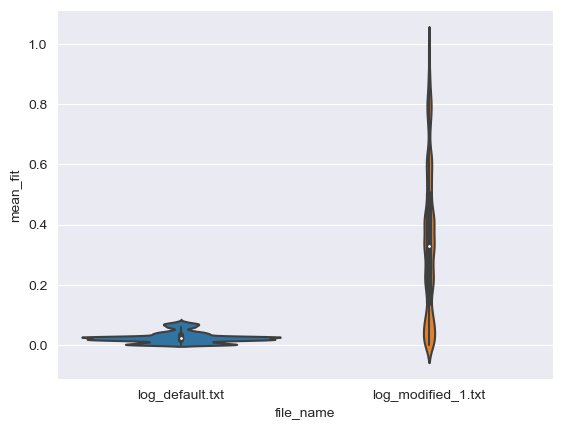

In [35]:
sns.violinplot(log_concat, y="mean_fit", x="file_name")

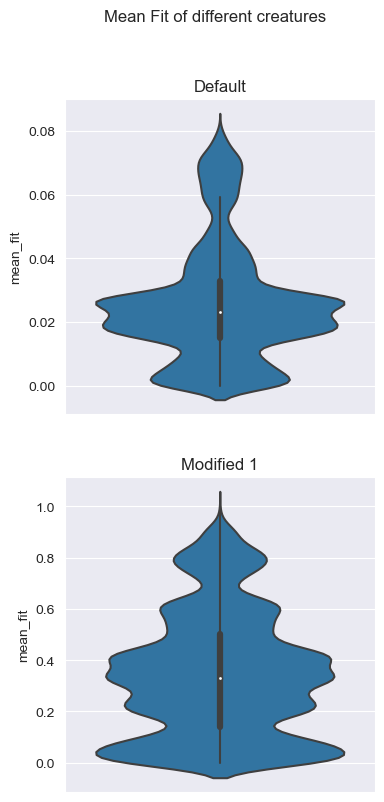

In [45]:
fig, axes = plt.subplots(2, 1, figsize=(4, 9), sharex="all")
fig.suptitle("Mean Fit of different creatures")
for i, file_name in enumerate(file_creature_name_association.keys()):
    sns.violinplot(file_name_filter(log_concat, file_name), y="mean_fit", ax=axes[i])
    axes[i].set(title=file_name.removeprefix("log_").removesuffix(".txt").replace("_", " ").title())
plt.savefig("plots/violin/violin.png", bbox_inches='tight')